In [2]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
import scipy.io

import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *

/Users/m/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
X = scipy.io.loadmat('../data/dataX.mat')['arr']
Y = scipy.io.loadmat('../data/dataY.mat')['arr']
# some daily information (5 weeks)
X = X[:-8, :-35]
Y = Y[8:, :-5]
print(X.shape, Y.shape)

(1081, 168) (1081, 24)


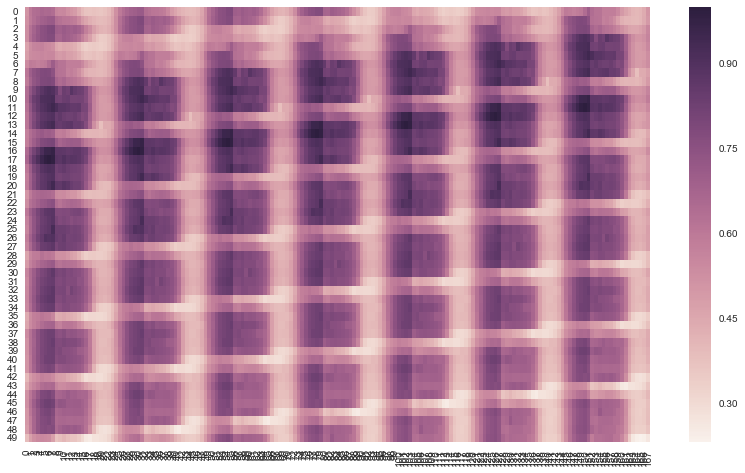

In [3]:
plt.figure(figsize=(14, 8))
sns.heatmap(X[:50, :])

plt.show()

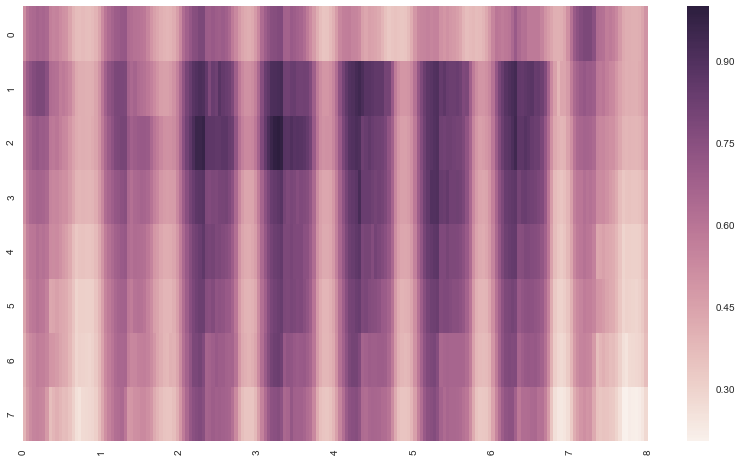

In [4]:
plt.figure(figsize=(14, 8))
mat = np.hstack([X[:50:7, :], Y[:50:7, :]])
sns.heatmap(mat)
start, end, stepsize = 0, mat.shape[1] + 1, 24
plt.xticks(np.arange(start, end, stepsize))
plt.show()

In [5]:
input_X = T.matrix()

def build_nn(n_features, n_hidden=20):
    net = {}
    net['l_input'] = InputLayer(shape=(None, n_features), input_var=input_X)
    net['l_hidden'] = DenseLayer(net['l_input'], num_units=n_hidden)
    net['l_out'] = DenseLayer(net['l_hidden'], num_units=n_features)
    return net

In [6]:
def iterate_minibatches(inputs, batchsize, shuffle=False):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [7]:
n_epochs = 20
batchsize = 16
n_hiddens = [60, 40]
Z = X.copy()
for ae in range(len(n_hiddens)):
    net = build_nn(Z.shape[1], n_hiddens[ae])
    weights = get_all_params(net['l_out'], trainable=True)
    recovered_X = get_output(net['l_out'])
    z = get_output(net['l_hidden'])
    loss = T.mean(lasagne.objectives.squared_error(input_X, recovered_X))
    updates = lasagne.updates.adam(loss, weights, learning_rate=0.00001)
    train = theano.function([input_X], loss, updates=updates)
    representation = theano.function([input_X], z)
    
    loss_array = []
    for epoch in range(n_epochs):
        k = 0
        loss_array.append(0)
        for batch in iterate_minibatches(Z, batchsize):
            loss_array[-1] += train(batch)
            k += 1
        loss_array[-1] /= k
        print("Autoencoder: {:d}, epoch: {:d}, loss: {:.3f}".format(ae+1, 
                                                                   epoch+1, loss_array[-1]))
    Z = representation(Z)

Autoencoder: 1, epoch: 1, loss: 0.162
Autoencoder: 1, epoch: 2, loss: 0.157
Autoencoder: 1, epoch: 3, loss: 0.152
Autoencoder: 1, epoch: 4, loss: 0.146
Autoencoder: 1, epoch: 5, loss: 0.140
Autoencoder: 1, epoch: 6, loss: 0.135
Autoencoder: 1, epoch: 7, loss: 0.129
Autoencoder: 1, epoch: 8, loss: 0.124
Autoencoder: 1, epoch: 9, loss: 0.120
Autoencoder: 1, epoch: 10, loss: 0.116
Autoencoder: 1, epoch: 11, loss: 0.111
Autoencoder: 1, epoch: 12, loss: 0.106
Autoencoder: 1, epoch: 13, loss: 0.101
Autoencoder: 1, epoch: 14, loss: 0.096
Autoencoder: 1, epoch: 15, loss: 0.092
Autoencoder: 1, epoch: 16, loss: 0.089
Autoencoder: 1, epoch: 17, loss: 0.086
Autoencoder: 1, epoch: 18, loss: 0.083
Autoencoder: 1, epoch: 19, loss: 0.080
Autoencoder: 1, epoch: 20, loss: 0.078
Autoencoder: 2, epoch: 1, loss: 0.407
Autoencoder: 2, epoch: 2, loss: 0.403
Autoencoder: 2, epoch: 3, loss: 0.399
Autoencoder: 2, epoch: 4, loss: 0.395
Autoencoder: 2, epoch: 5, loss: 0.390
Autoencoder: 2, epoch: 6, loss: 0.384
A

In [6]:
# X_train, X_test = Z[:700:7, :], Z[700::7, :]
# Y_train, Y_test = Y[:700:7, :], Y[700::7, :]

X_train, X_test = X[:700, :], X[700:, :]
Y_train, Y_test = Y[:700, :], Y[700:, :]

In [7]:
n_array = np.arange(2, 20)

best_mse = np.inf

for n in n_array:
    pls = PLSRegression(n_components=n, scale=False)
    pls.fit(X_train, Y_train)
    Y_pred = pls.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    if mse < best_mse:
        best_n = n
        best_mse = mse
best_n, best_mse

(17, 0.0011902963861976383)

In [12]:
pls = PLSRegression(n_components=20, scale=False)
pls.fit(X_train, Y_train)
Y_pred = pls.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
mse

0.0013504647658210012

In [10]:
pls = PLSRegression(n_components=best_n, scale=False)
pls.fit(X_train, Y_train)
Y_pred = pls.predict(X_test)
W = pls.x_weights_
coef = pls.coef_
x_rotations = pls.x_rotations_
y_rotations = pls.y_rotations_
x_scores = pls.x_scores_ 

In [11]:
def mape(Y_test, Y_pred, vector=False):
    n = Y_test.shape[0]
    m = Y_test.shape[1]
    if vector==False:
        res = np.sum(np.divide(np.abs(Y_test - Y_pred), Y_test)) * 100 / n / m
    else:
        res = np.sum(np.divide(np.abs(Y_test - Y_pred), Y_test), 0) * 100 / n  
    return res

In [12]:
print(mean_squared_error(Y_test, Y_pred))
print(mean_absolute_error(Y_test, Y_pred))
print(mape(Y_test, Y_pred))

0.00301456983626
0.0372994736923
11.8967328576


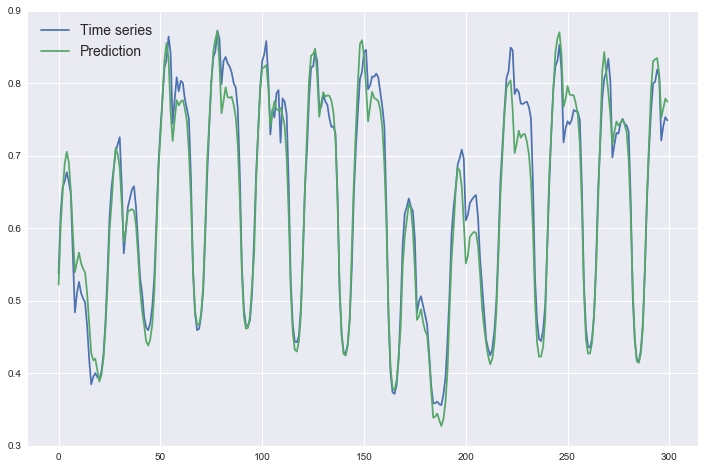

In [13]:
ts_test = Y_test.ravel()
ts_pred = Y_pred.ravel()

plt.figure(figsize=(12, 8))
plt.plot(ts_test[:300], label='Time series')
plt.plot(ts_pred[:300], label='Prediction')
plt.legend(fontsize=14)
plt.show()

In [15]:
def sumsqr(x, y):
    return mean_squared_error(x, y) * x.shape[0]

RSS (Residual Sum of Squares) 

In [27]:
rss = sumsqr(Y_test, Y_pred)
print(rss)

1.35222878387


In [29]:
def rss_func(Y_test, Y_pred):
    return sumsqr(Y_test, Y_pred)

In [32]:
print(rss_func(Y_test, Y_pred))

1.35222878387


TSS (Total Sum of Squares)

In [18]:
Y_mean = np.ones(Y_test.shape)
for i in range(Y_mean.shape[1]):
    Y_mean[:, i] = np.mean(Y_test, 0)[i]

In [30]:
tss = sumsqr(Y_test, Y_mean)
print(tss)

11.1152006772


In [31]:
def tss_func(Y_test):
    Y_mean = np.ones(Y_test.shape)
    for i in range(Y_mean.shape[1]):
        Y_mean[:, i] = np.mean(Y_test, 0)[i]
    return sumsqr(Y_test, Y_mean)

In [33]:
print(tss_func(Y_test))

11.1152006772


The adjusted coefficient of determination $R^2_{adj}$ considers adding redundant features and defined as folows
$$
R^2_{adj} =1−\frac{RSS/(m−k)}{TSS/(m-1)}
$$

The closer $R^2_{adj}$ to one the better model fits the target vector.


In [141]:
def rsq_adj(w, X, y, eps=10e-4):
    m = X.shape[0]
    p = np.sum(w != 0)
    tss = sumsqr(y, np.mean(y)*np.ones(y.shape))
    rss = sumsqr(y, np.dot(X, w))
    if (m == p + 1):
        res = 1 - (rss / eps) / (tss / (m - 1))
    else:
        res = 1 - (rss / (m - p - 1)) / (tss / (m - 1))
    return res
    

In [143]:
rsq_adj(w=coef[:, 0], X=x_rotations.transpose(), y=y_rotations[0, :])

3.8050518872849608

The Mallow’s $C_p$ criterion trades off the RSS and the number of features $p$. The Mallow’s
$C_p$ defined as
$$
    C_p = \frac{RSS_p}{RSS} - m + 2p
$$
where $RSS_p$ is similar to $RSS$, but computed with $p$ features only. In terms of this criterion the smaller $C_p$ the better feature subset.

In [156]:
def cp(X, w, y, rss):
    p = np.size(w) / w.shape[0]
    m = X.shape[0]
    return sumsqr(y, np.dot(X, w)) / rss - m + 2 * p

In [157]:
cp(w=coef[:, 0], X=x_rotations.transpose(), y=y_rotations[0, :], rss=rss)

999.73514830342071

Information criterion $BIC$ defined as
$$
BIC = RSS + p \log m.
$$
The smaller value of $BIC$ the better model fits the target vector.

In [160]:
def bic(X, y, w):
    rss = sumsqr(y, np.dot(X, w))
    return rss + X.shape[1] * np.log(X.shape[0])


In [161]:
bic(w=coef[:, 0], X=x_rotations.transpose(), y=y_rotations[0, :])

1481.7053956455259

The Belsley criterion

In [24]:
def my_collintest(X, eps=10e-4):
    '''
    Function computes matrix of the coefficient variance proportion according 
    to the Belsley approach to the multicollinear features detection. 

    Input:
    X - [m, n] - design matrix

    Output:
    VarDecomp - [n, n] - matrix of the coefficients variance proportion
    ''' 
    numObs, numVars = X.shape
    
    # Scale columns to length 1:
    colNormsX = np.sqrt(np.sum(np.square(X), 0))
    colNormsX[colNormsX == 0] = 1 # Avoid divide by 0
    XS = np.divide(X, np.matlib.repmat(colNormsX, numObs, 1))  # Scaled X

    # Compute SVD:
    _, sValue, V = np.linalg.svd(XS, full_matrices=False)

    # Compute condition indices:
    sValue[sValue < eps] = eps # Avoid divide by 0

    # Compute variance decomposition proportions:
    PHI = np.divide(np.square(V), np.matlib.repmat(np.square(sValue).transpose(), numVars,1)) 
    phi = np.sum(PHI, 1)
    VarDecomp = np.divide(PHI.transpose(), np.matlib.repmat(phi.transpose(), numVars, 1))
    return VarDecomp

In [25]:
def AlgBelsley(X, idxFeatures):
    '''
    Find index the worst feature, the most collinear, through the Belsley
    diagnosis
    [ intIdxDelFeature ] = algBelsley(X, idxFeatures)

    Input:
    X - [m, p] - full design matrix
    idxFeatures - [1, k] - vector containing indices of currently used features

    Output:
    intIdxDelFeature - [1, 1] - index of the deleted feature from idxFeature
                                vector
    '''
    VarDecomp = my_collintest(X[:, idxFeatures])
    idxMaxVarProp = np.argmax(VarDecomp[-1, :])
    intIdxDelFeature = idxFeatures[idxMaxVarProp]
    return intIdxDelFeature

The criterion of the selected features redundancy

In [177]:
def stability(X, y, w, s_0, X_unnorm):
    '''
    Function computes the number of features, 
    after their deleting the error function is less than par.s_0. 
    Deleting features is implemented through the Belsley procedure.     
     
    Input:
    X - [m, p] - design matrix with shrinkage number of predictors
    y - [m, 1] - target vector
    w - [p, 1] - vector of parameters, getting from algorithm, 
               which is tested
    s_0 - [1, 1] - limit acccepted error rate
    X_unnorm - [m, p] - design matrix with shrinkage number of predictors
                        but not normalized, because of the 
                        Belsley diagnostic implementation
    
    Output:
    d - [1,1] - maximum number of possibly deleting features
    '''
    idx_all_features = np.arange(w.shape[0])
    d = 0
    S = sumsqr(y, np.dot(X, w))
    while (S < s_0) & (idx_all_features.shape[0] > 1):
        idx_del = algBelsley(X_unnorm, idx_all_features)
        # хз мб надо исправить !!!!
        idx_all_features = idx_all_features.remove(idx_all_features[idx_all_features == idx_del])
        d = d + 1   
        S = sumsqr(y, np.dot(X[:, idx_all_features], w[idx_all_features]))
    return d


Scaled X

In [179]:
numObs, numVars = x_rotations.shape
colNormsX = np.sqrt(np.sum(np.square(x_rotations), 0))
colNormsX[colNormsX == 0] = 1 # Avoid divide by 0
XS = np.divide(x_rotations, np.matlib.repmat(colNormsX, numObs, 1))  # Scaled X

s_0 = 0.5

stability(w=coef[:, 0], X_unnorm=x_rotations.transpose(), y=y_rotations[0, :], s_0=s_0, X=XS.transpose())

0